# CNN: cats vs dogs classification

In [3]:
object
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf

## 准备数据

In [4]:
TRAIN_DIR = "./train/"
TEST_DIR = "./test1/"

TRAIN_SIZE = len([name for name in os.listdir(TRAIN_DIR)])  #返回指定的文件夹包含的文件或文件夹的名字的列表
TEST_SIZE = len([name for name in os.listdir(TEST_DIR)])
print("Number of training images:", TRAIN_SIZE)
print("Number of test images:", TEST_SIZE)

Number of training images: 25000
Number of test images: 12500


In [7]:
VALID_FRACTION = 0.2    # 验证集数据占比10%
BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

In [4]:
# 制作训练标签
train_filenames = os.listdir(TRAIN_DIR)
train_labels = []
for filename in train_filenames:
    label = filename.split('.')[0]
    train_labels.append(label)

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})


In [5]:
# 划分训练集验证集
train_df, valid_df = train_test_split(train_df, test_size=VALID_FRACTION)

In [6]:
# 训练集数据增强，利用多种能够生成可信图像的随机变换来增加样本
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

In [7]:
# 验证机不需要数据增强
valid_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
    )

In [8]:
# creating train and valid generators

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## 搭建模型

In [9]:
model = tf.keras.models.Sequential([
    # 图像通过Imagedatagenerator调整为150x150，带有3个字节颜色
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # 由于只有2个类可以预测，使用1个神经元和sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [11]:
# 训练时用的优化器、损失函数和准确率评测标准
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), # 优化器
    loss='binary_crossentropy',     # 损失函数
    metrics = ['accuracy'])         # 准确率

In [12]:
# 提前结束训练方法
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    restore_best_weights=True, 
    verbose=1,
    patience=5)

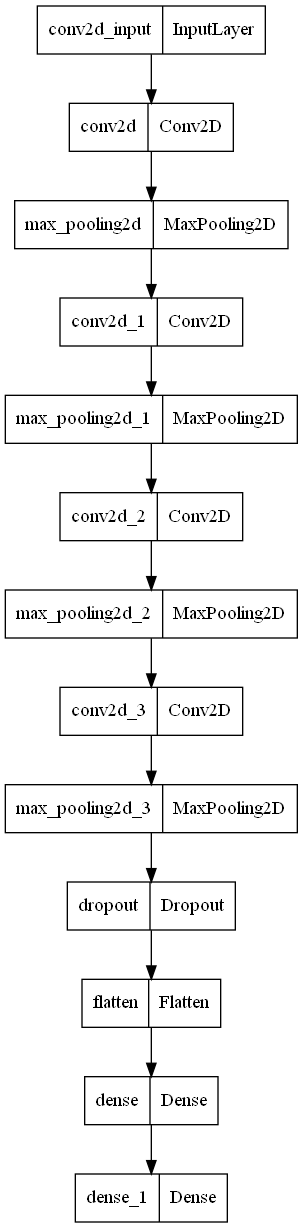

In [13]:
tf.keras.utils.plot_model(model)

## 训练

In [16]:
%%time

history = model.fit(train_generator,
    validation_data=valid_generator,
    steps_per_epoch=round(TRAIN_SIZE*(1.-VALID_FRACTION)/BATCH_SIZE),
    validation_steps=round(TRAIN_SIZE*VALID_FRACTION/BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[es],
    verbose=1)

Epoch 1/50
200/200 [==============================] - 541s 3s/step - loss: 0.6895 - accuracy: 0.5529 - val_loss: 0.6788 - val_accuracy: 0.5834
Epoch 2/50
200/200 [==============================] - 545s 3s/step - loss: 0.6471 - accuracy: 0.6303 - val_loss: 0.6040 - val_accuracy: 0.6856
Epoch 3/50
200/200 [==============================] - 513s 3s/step - loss: 0.6127 - accuracy: 0.6732 - val_loss: 0.5355 - val_accuracy: 0.7302
Epoch 4/50
200/200 [==============================] - 528s 3s/step - loss: 0.5807 - accuracy: 0.7001 - val_loss: 0.5271 - val_accuracy: 0.7482
Epoch 5/50
200/200 [==============================] - 509s 3s/step - loss: 0.5519 - accuracy: 0.7170 - val_loss: 0.5003 - val_accuracy: 0.7520
Epoch 6/50
200/200 [==============================] - 533s 3s/step - loss: 0.5347 - accuracy: 0.7327 - val_loss: 0.4434 - val_accuracy: 0.7904
Epoch 7/50
200/200 [==============================] - 483s 2s/step - loss: 0.5165 - accuracy: 0.7467 - val_loss: 0.4170 - val_accuracy: 0.8132

## 保存模型

In [17]:
model.save("model.h5")

## 可视化训练

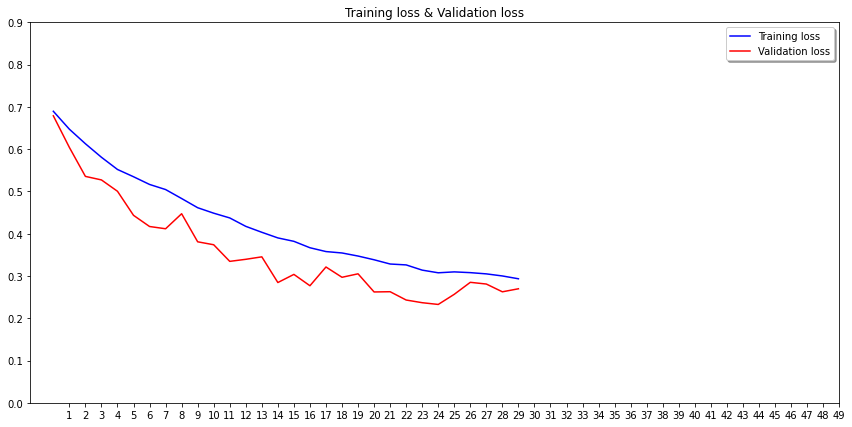

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14.5, 7))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.xticks(np.arange(1, EPOCHS, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc='best', shadow=True)
plt.title("Training loss & Validation loss")

plt.show()

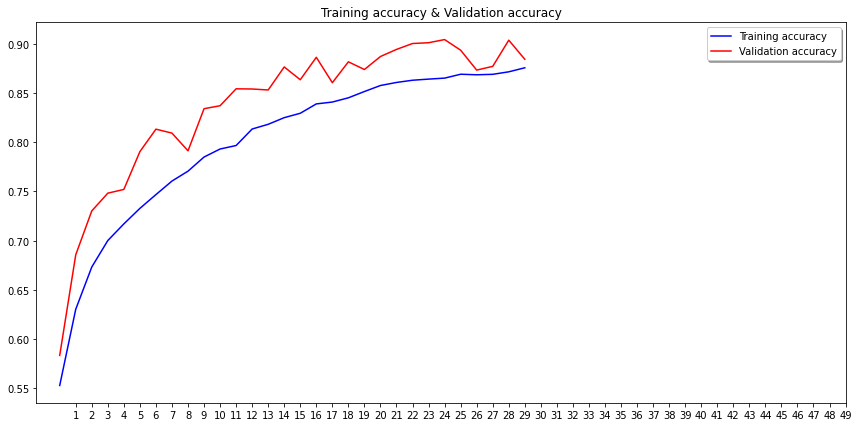

In [44]:
plt.figure(figsize=(14.5, 7))

plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(1, EPOCHS, 1))

plt.legend(loc='best', shadow=True)
plt.title("Training accuracy & Validation accuracy")

plt.show()

## 预测

In [46]:
# 准备测试数据

test_filenames = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'id': test_filenames
})

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    TEST_DIR, 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 12500 validated image filenames.


In [48]:
yhat = model.predict(test_generator, steps=np.ceil(TEST_SIZE/BATCH_SIZE))

125/125 [==============================] - 86s 685ms/step


In [51]:
# sigmoid返回0到1之间的概率，需要将其转换为一个整数类
yhat = [1 if y > 0.5 else 0 for y in yhat]

In [52]:
test_df['pred_label'] = yhat

In [57]:
# { 'dog': 1, 'cat': 0 }
test_df.head(10)

,id,pred_label
0,1.jpg,1
1,10.jpg,0
2,100.jpg,1
3,1000.jpg,1
4,10000.jpg,1
5,10001.jpg,0
6,10002.jpg,0
7,10003.jpg,1
8,10004.jpg,1
9,10005.jpg,0


In [59]:
# 转化标签 { 'dog': 1, 'cat': 0 }
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['pred_label'] = test_df['pred_label'].replace(label_map)
test_df.head(10)

,id,pred_label
0,1.jpg,dog
1,10.jpg,cat
2,100.jpg,dog
3,1000.jpg,dog
4,10000.jpg,dog
5,10001.jpg,cat
6,10002.jpg,cat
7,10003.jpg,dog
8,10004.jpg,dog
9,10005.jpg,cat


## 可视化图像的预测结果

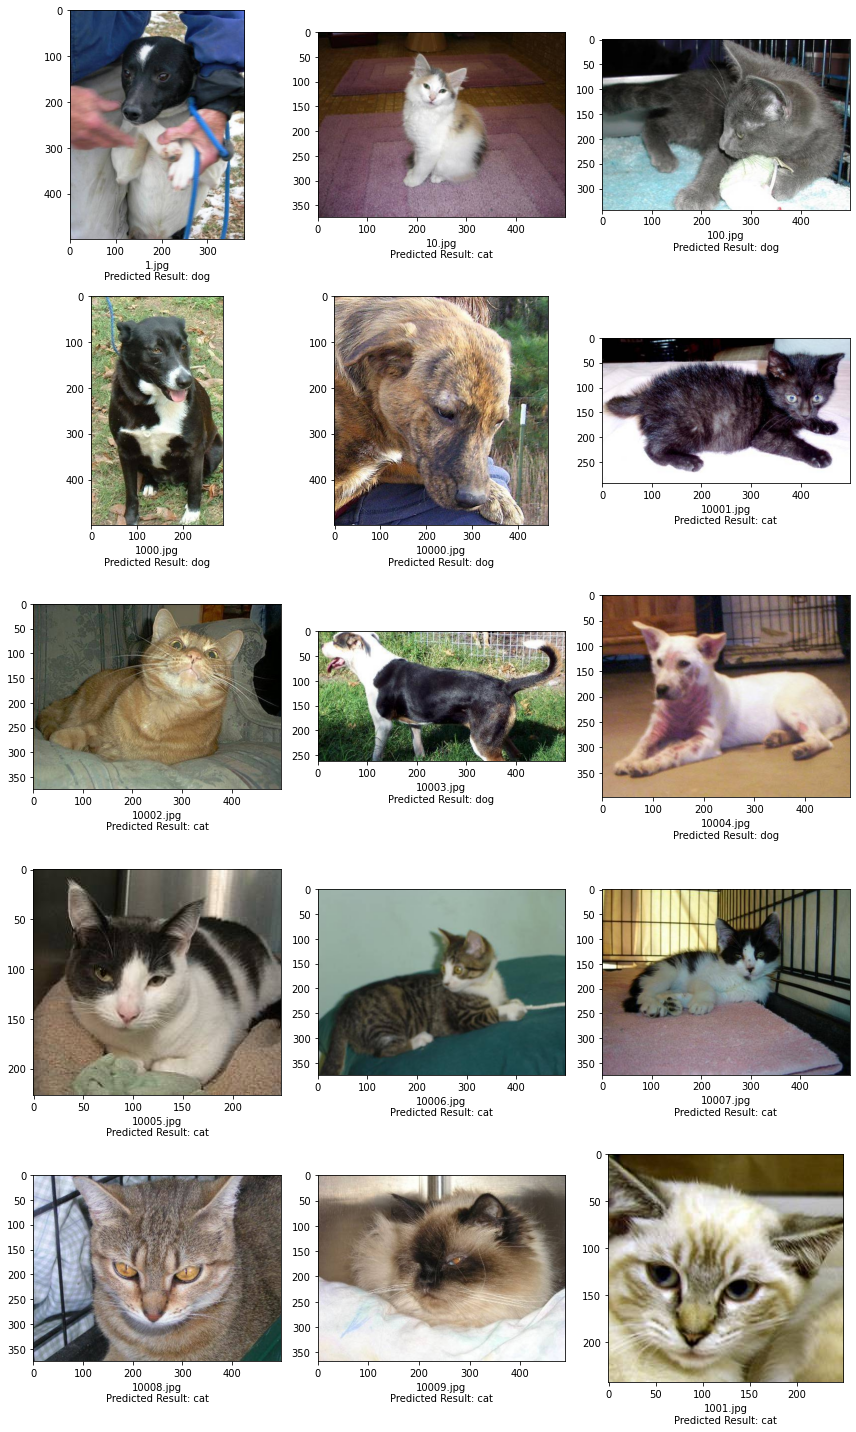

In [76]:
from PIL import Image

sample_test = test_df.head(15)
sample_test.head()
plt.figure(figsize=(12, 20))
for index, row in sample_test.iterrows():
    filename = row['id']
    category = row['pred_label']
    img_path = './test1/'+filename
    img = Image.open(img_path)
    # plt.figure(figsize=(1.5,1.5))
    # img.size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    # img = image ("./test1/"+filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    plt.subplot(5, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '\n' 'Predicted Result: ' + "{}".format(category))

plt.tight_layout()
plt.show()

## 加载保存模型，预测单张图像

In [5]:
loaded_model = tf.keras.models.load_model('./model.h5')

In [78]:
yhat_loaded_model = loaded_model.predict(test_generator, steps=np.ceil(TEST_SIZE/BATCH_SIZE))

125/125 [==============================] - 89s 708ms/step


In [8]:
import cv2
image = cv2.imread('./test1/10032.jpg')
image = cv2.resize(image,(IMAGE_WIDTH,IMAGE_HEIGHT))
img0 = (image.reshape(1,150,150,3).astype("float32"))/255    # 归一化
predict = loaded_model.predict(img0)

1/1 [==============================] - 0s 436ms/step


In [10]:
predict = 1 if predict[0][0] > 0.5 else 0

In [11]:
if predict == 0:
    print('识别为：猫')
else:
    image2=cv2.putText(image, 'dog', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
    print('识别为：狗')

识别为：猫


![10032.jpg](./test1/10032.jpg)